In [1]:
from collections import Counter,defaultdict
from bs4 import BeautifulSoup as bs
from bs4 import Comment
import os
import glob
import nltk
import math
import urllib2
import time
import numpy as np
import progressbar
from __future__ import division

In [4]:
path_to_folder = 'C:\\Users\\Isobel\\Documents\\auc\\textmining\\erowid_text'
filenames = os.listdir(path_to_folder)

test_files = filenames
sample = filenames[:10]


In [7]:
#because of the fact that we downloaded the data to file, decided to make smaller dict 
# ref is the experience number (and therefore file name)
# {ref {drug: gender}}

def retrieve_drug_and_gender(folder):
    """
    takes a folder and opens the files inside
    then finds the foottable and extracts the gender
    then finds the beginning table and extracts the drug   
    """
    drug_dict = {}
    #put this back os.listdir
    for f in (folder):
        drug_dict[f] = {}
        open_file = open(path_to_folder + '//' + f, 'r')
        bs_f = bs(open_file, "lxml")
        #find the html table with the class footdata
        # write a check for the table
        if (bs_f.find(class_='footdata')):
            #print "yes"
            end_table = bs_f.find(class_='footdata')
            rows = end_table.findAll('tr')
            #print rows
            #the gender is listed in the table data text as the 3rd element in the table
            gender_in_table = [[td.text for td in tr.findAll("td")] for tr in rows]
            g = gender_in_table[1]
            #clumsy function that takes the 0th element of the list from g  and partitions it to return the
            #second substring
            gender = g[0].partition(':')[2]
            #get the table containing the drug information
            drug_class = [td.find('a') for td in bs_f.findAll('td', {'class' : 'dosechart-substance'})]
            #take a set of the list to remove duplicate entries
            drug = set([drug.text for drug in drug_class if drug])
            #convert to string to use in dict
            # naiave way to remove unwanted characters from string
            drug = str(drug).strip("set([")
            drug = str(drug).strip("])")
            drug = drug.lower()
            #print drug
            drug_dict[f][drug] = gender
        else:
            pass
    return drug_dict

#a list of genders and the drugs
#data_set = retrieve_drug_and_gender(absolute_urls)

test = retrieve_drug_and_gender(sample)
#print test 

test_dict =  retrieve_drug_and_gender(test_files)

In [9]:
def count_gender(drug_gender_dict):
    """
    takes output of retrieve_drug_and_gender and 
    returns a dict of theccount of each gender for each drug
    """
    male_dict = {}
    female_dict = {}
    #select the second list in the item -> this is the part 
    #containing the information about gender
    for i in drug_gender_dict.values():
        for gender in i.values():
            #if gender is male, male_count is + 1
            if "Male" in gender:
                # we need to add 1 to the count specific to that drug
                #use a set to ensure no repetition of drug name in table
                for drug in i.keys():
                    if not drug in male_dict:
                        #if the drug is not already a key in the dict, then the count is 1
                        # as we havent seen it before
                        male_dict[drug] = 1
                    else:
                        # the count is incremented by 1
                        male_dict[drug] += 1
            #add 1 to female count if the gender is female
            if "Female" in gender:
                #check that there is no repetition of the same drug in a single entry
                for drug in i.keys():
                    if not drug in female_dict:
                        #the count is 1
                        female_dict[drug] = 1 
                    else:
                        # the count is incremented by 1
                        female_dict[drug] += 1
            else:
                #if gender is not specified, we ignore it
                pass
    return female_dict, male_dict

In [10]:
gender_count_tuple = count_gender(test_dict)

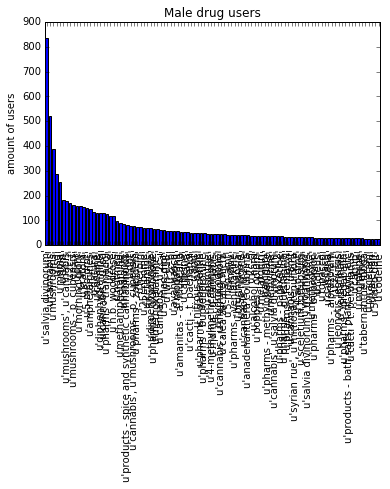

In [11]:
#display the results as bar plots

%matplotlib inline
import matplotlib.pyplot as plt


#the first dict is female drug users
female_drugs = gender_count_tuple[0]
#clean the empty string values '' from the dict
cleaned_female_drugs = {i:female_drugs[i] for i in female_drugs if i!=''}
#the second dict is male drug users
male_drugs = gender_count_tuple[1]
#clean the empty string values from the dict
cleaned_male_drugs = {i:male_drugs[i] for i in male_drugs if i!=''}

#get the top 5 used drugs from male and female users useing the cleaned dicts
top_female_drugs = Counter(cleaned_female_drugs).most_common(5)
top_male_drugs = Counter(cleaned_male_drugs).most_common(100)
'print top_male_drugs'

#display the results as a bar chart
#female drug users plotted onto a graph
plt.bar(range(len(top_female_drugs)), [x[1] for x in top_female_drugs], align="center")
plt.xticks(range(len(top_female_drugs)), [x[0] for x in top_female_drugs], rotation='vertical')
#label the axis
plt.ylabel('amount of users')
plt.title('Female drug users')

#plt.show()

#male drug users plotted onto a drug
plt.bar(range(len(top_male_drugs)), [y[1] for y in top_male_drugs], align="center")
plt.xticks(range(len(top_male_drugs)), [y[0] for y in top_male_drugs], rotation='vertical')
#label the axis 
plt.ylabel('amount of users')
plt.title('Male drug users')

#plt.show()

#print set(male_drugs.keys())

In [20]:
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords 

stop_words = set(stopwords.words('english'))

In [9]:
#function to make clouds 
def make_cloud(text):
    wordcloud = WordCloud(max_font_size=40, relative_scaling=.5).generate(text)  # Note that this is different from the code on the web! You must specify the font path
    # Open a plot of the generated image.
    plt.imshow(wordcloud)
    plt.axis("off")
    return plt.show()

In [15]:
#parent url
wikipedia_url = "https://en.wikipedia.org/wiki/List_of_psychedelic_drugs"

def read_links(start_page):
    """
    takes a url and returns the links on that page
    """
    tags = []
    response = urllib2.urlopen(start_page)
    #convert to soup in order to strain out the anchors and the urls
    soup = bs(response.read(), "lxml")
    text = soup.encode("utf-8",'ignore')
    psychedelics = soup.find(id="Serotonergic_psychedelics_.28serotonin_5-HT2A_receptor_agonists.29")
    drugs = soup.findAll('a')
    for ultag in soup.find_all('ul'):
        for litag in ultag.find_all('li'):
            for atag in litag.find_all('a'):
                tags.append(str(atag.text.encode("utf-8", 'ignore')).lower())
    return tags

    
    
drug_list = read_links(wikipedia_url)

#<span class="mw-headline" id="Empathogens.2Fentactogens_.28serotonin_.285-HT.29_releasing_agents.29"><a href="/wiki/Empathogen-entactogen" title="Empathogen-entactogen">Empathogens/entactogens</a> <i>(<a href="/wiki/Serotonin_releasing_agent" title="Serotonin releasing agent">serotonin (5-HT) releasing agents</a>)</i></span>

#print drug_list[:130]

list_index = drug_list.index('tryptamines')
#endpoint = drug_list.index('MDMA')
#print endpoint
start_point = drug_list[list_index:]

end = drug_list.index('para-chloroamphetamine')

drug_list_full = start_point[:end]

print drug_list_full

['tryptamines', 'alkylated', 'psilocin', 'psilocybe', 'psilocybin', 'psilocybe', 'dephosphorylation', 'bufotenin', 'psychoactive toads', 'baeocystin', 'psilocybe', 'aeruginascin', 'inocybe aeruginascens', '5-meo-dmt', 'psychoactive toads', 'demethylation', 'n,n-dimethyltryptamine', 'ayahuasca', 'trace amine', '5-bromo-dmt', 'invertebrates', 'n-methyl-n-ethyltryptamine', 'n-methyl-n-isopropyltryptamine', 'methyl-n-propyltryptamine', 'n,n-diethyltryptamine', 'n-ethyl-n-isopropyltryptamine', 'n-methyl-n-butyltryptamine', 'n-propyl-n-isopropyltryptamine', 'n,n-dipropyltryptamine', 'n,n-diisopropyltryptamine', 'n,n-diallyltryptamine', 'n,n-dibutyltryptamine', 'n-ethyltryptamine', 'n-methyltryptamine', 'trimethyltryptamine', '2,n,n-tmt', '5,n,n-tmt', '7,n,n-tmt', '\xce\xb1-methyltryptamine', '\xce\xb1-ethyltryptamine', '\xce\xb1,n-dmt', '\xce\xb1,n,n-trimethyltryptamine', 'ethocybin', '4-ho-met', '4-ho-det', '4-ho-mpt', '4-ho-mipt', '4-ho-malt', '4-ho-dpt', '4-ho-dipt', '4-ho-dalt', '4-ho-db

In [118]:
p_drugs = ['LSD', 'Mushrooms', 'Salvia divinorum', 'DXM', '2C-I', 'Cacti - T. pachanoi', 'Ayahuasca', 'H.B. Woodrose', 'Mushrooms - P. cubensis', 'DMT', 'Datura', 'Morning Glory', 'Kratom', '2C-E', 'DPT', 'AMT', '25I-NBOMe', 'Syrian Rue']

'''print [type(i[1].keys()) for i in test_dict.items()[:2]]'''

for i in test_dict.items()[:2]:
    for e in i[1].keys():
        print type(e)
        print e

<type 'str'>
u'5-MeO-DMT'
<type 'str'>
u'Cannabis'


In [18]:
"""
psychadelic drugs were selected acording to http://psychedelics.com/psychedelics-definition/psychedelic-drug-list/
"""

def find_LSD(in_dict, drug_list):
    """
    takes a dict and converts it to it's items (a tuple)
    if the desired drug is in the second part of the tuple
    we return the first part of the tuple
    which is the ID"""
    ID = []
    item = in_dict.items()
    for i in item:
        # print "item"
        # print i
        for e in i[1].keys():
            # print "string"
            # print e 
            for d in drug_list:
                # print "d"
                # print d
                if d in e:
                    # print "d found in e"
                    # print e 
                    key_id = i[0]
                    ID.append(key_id)
    return ID

# get the first element of the tuple 
LSD_LIST = find_LSD(test_dict, drug_list_full)
# rest_data_list = find_LSD(test_dict, p_drugs)[1]

LSD_ID = set(LSD_LIST)

list_of_id = (test_dict.keys())

def get_rest_id(list_id, list_p_id):
    rest_id = []
    for drug_id in list_id:
        #print "drug id"
        #print drug_id
        if drug_id in list_p_id:
            pass
        else:
            rest_id.append(drug_id)
    return rest_id

non_psychoactive_id = (get_rest_id(list_of_id, LSD_ID))

rest_data = set(non_psychoactive_id)
# check if duplicates
print "check duplicates"
#print [i for i in rest_data if i == e for e in LSD_ID]
print "lsd list"
print LSD_LIST[:10]
print"non pschoactive id"
print non_psychoactive_id[:10]

# print "rest"
# print rest_data

# print [i for i in LSD_ID if i == e in rest_data]

# try_this = [i for i in LSD_ID if i != list_of_id]
# print "trial"
# print try_this
# print "test"
# print [i for i in LSD_ID if i == e in try_this]

check duplicates
lsd list
['35237', '35237', '35237', '73393', '35549', '35549', '35549', '35549', '35549', '35549']
non pschoactive id
['35234', '35235', '35546', '73397', '35542', '35238', '101767', '11541', '101768', '55292']


In [21]:
def clean_text(list_of_id):
    no_stop_words = []
    l = []
    for i in list_of_id:
        """
        takes a list of drug ids and opens the corresponding files
        then returns the cleaned and tokenised message
        """
        open_file = open(path_to_folder + '//' + i, 'r')
        text = open_file.read()
        #extract the txt after the <!-- Start Body --> comment
        body = text.partition('<!-- Start Body -->')[2]
        #extract text before <!-- End Body --> comment
        message = body.partition('<!-- End Body -->')[0]
        #lower case and remove the <br>
        message = message.lower()
        no_br = message.replace('<br>', '')
        no_slash_br = no_br.replace('<br/>', '')
        #remove stop words
        no_stop_words = [w for w in no_slash_br.split() if w not in stop_words]
        l.extend(no_stop_words)
    return l
        
print "psychoactives tokenised"
tokenised = clean_text(LSD_ID)
print tokenised[:10]
print "amount of pyschoactive words"
print len(tokenised)
"""
the rest of the data is also cleaned
"""
rest_tokenised = clean_text(non_psychoactive_id)
print "rest"
print rest_tokenised[:10]
print "amount of rest_tokenised words"
print len(rest_tokenised)

psychoactives tokenised
['belong', 'psychedelics', 'club', 'ideally', 'meets', 'last', 'saturday', 'every', 'month', 'try']
amount of pyschoactive words
2692980
rest
['one', 'people', 'definitely', "'his", 'head', "straight.'", 'get', 'good', 'grades', 'school,']
amount of rest_tokenised words
7183684


In [22]:
count = Counter()

def word_count(l):
    """
    takes a list and returns count of words
    """
    for word in l:
        count[word] += 1
    return count

In [23]:
print word_count(tokenised).most_common(30)
print word_count(rest_tokenised).most_common(30)

[('like', 21574), ('would', 16182), ('felt', 14629), ('feel', 13081), ('time', 12815), ('one', 11601), ('could', 10850), ('still', 10527), ('get', 10128), ('around', 9554), ('back', 9516), ('feeling', 9428), ('much', 9273), ('really', 9130), ('experience', 8096), ('-', 7683), ('first', 7391), ("i'm", 7281), ('take', 7186), ('took', 7016), ('go', 6953), ('got', 6889), ('little', 6862), ('even', 6740), ('trip', 6637), ('started', 6565), ('went', 6253), ('also', 6194), ('effects', 6138), ('it.', 6107)]
[('like', 82495), ('would', 59527), ('felt', 57569), ('time', 47199), ('one', 46088), ('could', 43246), ('feel', 42560), ('get', 38312), ('back', 38013), ('still', 35044), ('around', 33923), ('feeling', 33451), ('really', 33200), ('much', 31025), ('got', 28538), ('first', 28460), ('started', 28161), ('experience', 27944), ('took', 26410), ('went', 26259), ('go', 25495), ('even', 25393), ('little', 24582), ("i'm", 24122), ('it.', 23869), ('take', 23632), ('-', 23576), ('going', 23525), ('me.

In [24]:
#make the list of spirit words - primarily taken from wikipedia

spiritual_words = ['god', 'spirit', 'heaven', 'hell', 'universe','magic','atheist', 'creation', 'concious', 'exist']

def specific_word_count(list_words, counter_object):
    wc = {}
    for w in list_words:
        w_count = counter_object[w]
        wc[w] = w_count
    return wc

spirit_count =  specific_word_count(spiritual_words, word_count(tokenised))
rest_spirit_count = specific_word_count(spiritual_words, word_count(rest_tokenised))
        

print spirit_count
print rest_spirit_count


"""
acorrding to https://www.lancaster.ac.uk/fss/courses/ling/corpus/blue/l05_3.htm
word frequency is often normalised by Frequency per million words = ( frequency ÷ text no. words ) x 1,000,000 
"""
amount_psychoactive_words = len(tokenised)
amount_non_psychoactives = len(rest_tokenised)

#the observed normalised frequency of spiritual words in pyschadelic drugs
print "psychodelics"
normalised_frequency = [(v/amount_psychoactive_words)*1000000 for v in spirit_count.values()]
print normalised_frequency
#the expected normalised frequency words accross other drugs
print "rest"
rest_normalised_frequency = [(v/amount_non_psychoactives)*1000000 for v in rest_spirit_count.values()]
print rest_normalised_frequency


{'heaven': 422, 'magic': 1194, 'concious': 72, 'god': 3362, 'creation': 287, 'atheist': 57, 'exist': 826, 'universe': 2687, 'hell': 3354, 'spirit': 1389}
{'heaven': 684, 'magic': 1970, 'concious': 118, 'god': 5530, 'creation': 454, 'atheist': 90, 'exist': 1342, 'universe': 4234, 'hell': 5470, 'spirit': 2192}
psychodelics
[156.7037259838543, 443.3749972149812, 26.73618073658178, 1248.4311060609436, 106.57338710276349, 21.166143083127242, 306.7234067835632, 997.7794116554895, 1245.4604193124344, 515.78548670989]
rest
[95.21576951324697, 274.23255254546274, 16.426112284449037, 769.8000079068065, 63.1987709927107, 12.528390725427231, 186.8122261502594, 589.3911814606545, 761.4477474231884, 305.1359163348499]


In [17]:
#make a graph of the spirit words

#display the results as bar plots
%matplotlib qt 


plt.bar(range(len(spirit_count.values())), [x for x in spirit_count.values()], align="center")
plt.xticks(range(len(spirit_count.keys())), [x for x in spirit_count.keys()], rotation='vertical')
#label the axis
plt.ylabel('word count')
plt.title('Spiritualism in pschadelics?')

plt.show()


In [ ]:
import pandas as pd

In [ ]:
"""
we make a panda from the spirit count, which a dictionary of the spiritual words in the reports
"""
psychadelic_panda = pd.DataFrame.from_dict(spirit_count, orient='index')
rest_panda = pd.DataFrame.from_dict(rest_spirit_count, orient='index')

print psychadelic_panda


In [25]:
import scipy.stats  
#calculate chi squared
#sum(((observed/expected)^2)/expected)

scipy.stats.chisquare(normalised_frequency, f_exp=rest_normalised_frequency)



Power_divergenceResult(statistic=1296.8442867656056, pvalue=1.4860939588891628e-273)

In [ ]:
"""
mean of the spirit words occuring out of the total tokenised words in psychadelic
"""
p_total = len(word_count(tokenised))
print p_total
psychadelic_panda['ratio'] = psychadelic_panda.ix[:,'0':].sum(axis=1)/p_total

#print psychadelic_panda

In [ ]:
"""
mean of the spirit words occuring out of the total tokenised words in rest
"""
r_total = len(word_count(tokenised))
#print r_total
rest_panda['ratio'] = rest_panda.ix[:,'0':].sum(axis=1)/r_total
#print rest_panda

In [ ]:
rest_ratios = rest_panda[rest_panda.columns[1]].get_values()
psychadelic_ratios = psychadelic_panda[psychadelic_panda.columns[1]].get_values()

#chisquare(observed_values, f_exp=expected_values)
chi_square_ratios = scipy.stats.chisquare(psychadelic_ratios, f_exp=rest_ratios)
print chi_square_ratios